In [52]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
from scipy import stats
import cv2
from pyspark import SparkContext, SparkConf
import skimage
from pathlib import Path

def mean2(x):
    y = np.sum(x) / np.size(x);
    return y
def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r
from copy import deepcopy
from skimage.filters import threshold_otsu,threshold_li
import glob
from IPython.display import clear_output
import scipy.io as spio
import pims
import fnmatch
from skimage import io
import os.path, time

In [53]:
expdir='/Volumes/ukps-all$/AG-Rizzoli/Tal/FromSinem/190131_NeuroBurst/' #master folder
protein="int" #TNR,Agg,WFA,HABP

In [54]:
results = {"calcium recording filename":[], "corresponding syt/clumps filename":[],
           "clumpschannelno":[],"synapsechannelno":[],
           "spontaneous or stimulation":[],
           "magnification":[],
           "Manual mask from matlab GUI":[],
           
           "calcium mean intensity whole frame":[],
           "calcium mean intensity in rois":[],
           "calcium mean intensity in rois - vector for each roi":[],
           "calcium [f(t)-f(0)]/f(0) in rois":[],
           "calcium [f(t)-f(0)]/f(0) in rois - vector for each roi":[],
           "total calcium influx (AOC of [f(t)-f(0)]/f(0) in rois)":[],
           "calcium slope downwards":[],
           
           #"synapse mask (dilated syt1)":[],
           #"df/f under dilated syt mask":[],
           
           "synchronicity (pearson)":[],
           "synchronicity (no. of peaks)":[]}

path = os.path.dirname(expdir)  
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))      
for i in range(0,len(filelist)):
    if ("dont" in str(filelist[i]))==False:
        if ("ignore for analysis" in str(filelist[i]))==False:
            #if ("20191029" in str(filelist[i]))==False:
                if ("syt" in str(filelist[i]))==False:

                    if filelist[i].endswith(".tif"): 
                        print(filelist[i])
                        results["calcium recording filename"].append(filelist[i])


                        channeldir="/".join(filelist[i].split("/")[:-2])
                        exec(open(channeldir+"/channels.txt").read())
                        results["clumpschannelno"].append(clumpschannelno)
                        results["synapsechannelno"].append(synapsechannelno)

                        if ('spontaneous' in str(filelist[i]))==True:
                            results["spontaneous or stimulation"].append('spontaneous')
                            print('spont')

                        else:
                            results["spontaneous or stimulation"].append('stim')
                            print('stim')
                        if "60x" in str(filelist[i]):
                            results["magnification"].append('60x')
                        else:
                            results["magnification"].append('20x')

                        #add syt image if exists
                        a=filelist[i]
                        no=a.split('field')[-1][0]

                        filelist_syt = []
                        syt_image=[]
                        for root, _, filenames in os.walk(path):
                             for filename in filenames:
                                 filelist_syt.append(os.path.join(root, filename))      
                        for ij in range(0,len(filelist_syt)):
                            if ("syt" in str(filelist_syt[ij])):
                                if (a.split('field')[0]+'field'+str(no)) in str(filelist_syt[ij]):
                                    syt_image.append(filelist_syt[ij])
                        if len(syt_image)>0:
                            results["corresponding syt/clumps filename"].append(syt_image[:])
                            print(syt_image[:])
                        else:
                            results["corresponding syt/clumps filename"].append('no image')

/Volumes/ukps-all$/AG-Rizzoli/Tal/FromSinem/190131_NeuroBurst/Neuroburst_12ul001.tif
stim
/Volumes/ukps-all$/AG-Rizzoli/Tal/FromSinem/190131_NeuroBurst/Neuroburst_12ul002.tif
stim
/Volumes/ukps-all$/AG-Rizzoli/Tal/FromSinem/190131_NeuroBurst/Neuroburst_25ul001.tif
stim
/Volumes/ukps-all$/AG-Rizzoli/Tal/FromSinem/190131_NeuroBurst/Neuroburst_3ul001.tif
stim
/Volumes/ukps-all$/AG-Rizzoli/Tal/FromSinem/190131_NeuroBurst/Neuroburst_50ul001.tif
stim
/Volumes/ukps-all$/AG-Rizzoli/Tal/FromSinem/190131_NeuroBurst/Neuroburst_50ul003.tif
stim
/Volumes/ukps-all$/AG-Rizzoli/Tal/FromSinem/190131_NeuroBurst/Neuroburst_50ul002.tif
stim


## load matlab 

In [55]:
for im in range(0,len(results["calcium recording filename"])): 
    file=results["calcium recording filename"][im][:-4]+'_dendritesmask.mat'
    from pathlib import Path
    my_file = Path(file)
    if my_file.exists():
        #print(file)
        mat = spio.loadmat(file, squeeze_me=True)
        mask=mat['totMask']>0.99
        if np.sum(mask)==0:
            print(file)
        results["Manual mask from matlab GUI"].append(mask)
    else:
        results["Manual mask from matlab GUI"].append(np.nan)
#clear_output()        
print("Done!")

Done!


## loop over images

In [56]:
from scipy.stats import linregress
counter=0
for im in range(0,len(results["calcium recording filename"])):
    flagstim=False
    


    image_name=results["calcium recording filename"][im]
    image = io.imread(image_name)
    matlab_mask=results["Manual mask from matlab GUI"][im]
    
    #segment
    image[0][~matlab_mask]=0
    labeled,cc_num=ndi.label(image[0])
    counter=counter+cc_num
    
    #background 
    bg=np.mean(ndi.median_filter(image[0],size=5))+0*np.std(ndi.median_filter(image[0],size=5))
    #image=image-bg
    #image[image<0]=0
    
    mean_int_all_spot_vector=[]
    df_over_f_all_spot_vector=[]
    
    if results["spontaneous or stimulation"][im]=="stim":
        flagstim=True
        
    if cc_num==1:
        mean_int_spot=image[:,labeled==0].mean(axis=1)
        if flagstim:
            f0=mean_int_spot[0]
        else:
            f0=mean_int_spot[mean_int_spot>0].min()
        if f0==0:
            if flagstim:
                f0=mean_int_spot[mean_int_spot>0].min()
            else:
                f0=mean_int_spot[mean_int_spot>0].min()
        
        mean_int_all_spot_vector=mean_int_spot[1:-1]
        df_over_f_all_spot_vector= (np.subtract(mean_int_spot,f0)/f0)[1:39]
    
    else:
        for spot in range(0,cc_num):
            mean_int_spot=image[:,labeled==spot].mean(axis=1)
            if np.isnan(mean_int_spot).any():
                #print('nan')
                continue
            elif np.isinf(mean_int_spot).any():
                #print('inf')
                continue
            if flagstim:
                f0=mean_int_spot[0]
            else:
                f0=mean_int_spot[mean_int_spot>0].min()
            if f0==0:
                if flagstim:
                    f0=mean_int_spot[mean_int_spot>0].min()
                else:
                    f0=mean_int_spot[mean_int_spot>0].min()
            df_over_f_spot=(np.subtract(mean_int_spot,f0))/f0
            df_over_f_spot
            if np.isnan(df_over_f_spot).any():
                #print('nan')
                continue
            elif np.isinf(df_over_f_spot).any():
                #print('inf')
                continue
            else:
                #print('cool')

                mean_int_all_spot_vector.append(mean_int_spot[1:39])
                df_over_f_all_spot_vector.append(df_over_f_spot[1:39])
        
            if mean_int_spot[0]==0:
                print(image_name)
            print(len(mean_int_spot))
        
    
    mean_int_all_spot_vector=np.array(mean_int_all_spot_vector)
    
    df_over_f_all_spot_vector=np.array(df_over_f_all_spot_vector)
    
    '''#drop nans
    mask = np.all(np.isnan(mean_int_all_spot_vector) | np.equal(mean_int_all_spot_vector, 0), axis=1)
    mean_int_all_spot_vector=mean_int_all_spot_vector[~mask]
    
    mask = np.all(np.isnan(df_over_f_all_spot_vector) | np.equal(df_over_f_all_spot_vector, 0), axis=1)
    df_over_f_all_spot_vector=df_over_f_all_spot_vector[~mask]
    mask = np.all(np.isinf(df_over_f_all_spot_vector) | np.equal(df_over_f_all_spot_vector, 0), axis=1)
    df_over_f_all_spot_vector=df_over_f_all_spot_vector[~mask]'''
    
    if np.any(np.isnan(mean_int_all_spot_vector)):
        #print(image_name)
        print(np.sum(matlab_mask))
        print(mean_int_spot)
        print(mean_int_all_spot_vector)
        results["calcium mean intensity whole frame"].append(np.nan)
        results["calcium mean intensity in rois"].append(np.nan)
        results["calcium mean intensity in rois - vector for each roi"].append(np.nan)
        results["calcium [f(t)-f(0)]/f(0) in rois"].append(np.nan)
        results["calcium [f(t)-f(0)]/f(0) in rois - vector for each roi"].append(np.nan)
        results["total calcium influx (AOC of [f(t)-f(0)]/f(0) in rois)"].append(np.nan)
        results["calcium slope downwards"].append(np.nan)
        results["synchronicity (pearson)"].append(np.nan)
        results["synchronicity (no. of peaks)"].append(np.nan)
        break
        
    if cc_num==1:
        df_over_f_all_spots_in_image=df_over_f_all_spot_vector
        mean_int_all_spots_in_image=mean_int_all_spot_vector
    else:
        mean_int_all_spots_in_image=np.nanmean(mean_int_all_spot_vector,axis=0)
        df_over_f_all_spots_in_image=np.nanmean(df_over_f_all_spot_vector,axis=0)
    
    aoc_all_spots_in_image= np.trapz(df_over_f_all_spots_in_image,axis=0)
    pearson_all_spots_in_image=np.mean(np.corrcoef(df_over_f_all_spot_vector))
    
    #no_peaks
    if flagstim:
        threshold=1
    else:
        threshold=10
        
    stack=df_over_f_all_spots_in_image
    prev = stack[0] or 0.01
    peaks = []
    no_peaks_in_image=0
    for i in range(0,100):
        if no_peaks_in_image==int(0):
            for num, i in enumerate(stack[1:], 1):
                if (i - prev) / prev > threshold:
                    peaks.append(num)
                prev = i or 0.001
            threshold=threshold-0.1
            no_peaks_in_image=int(len(peaks))
            print(threshold)
            print(len(peaks))
        else:
            break
    
    #calculate slope
    if flagstim:
        if no_peaks_in_image==0:
            peaks=1
        else:
            peaks=peaks[0]
        X=np.arange(peaks,peaks+10)
        Y=df_over_f_all_spots_in_image[peaks:peaks+10]
        slope,_,_,_,_=linregress(X, Y)
    else:
        slope=np.nan

    #mean intensity full image
    mean_int_full=image.mean(axis=1).mean(axis=1)
    
    results["calcium mean intensity whole frame"].append(mean_int_full)
    results["calcium mean intensity in rois"].append(mean_int_all_spots_in_image)
    results["calcium mean intensity in rois - vector for each roi"].append(mean_int_all_spot_vector)
    results["calcium [f(t)-f(0)]/f(0) in rois"].append(df_over_f_all_spots_in_image)
    results["calcium [f(t)-f(0)]/f(0) in rois - vector for each roi"].append(df_over_f_all_spot_vector)
    results["total calcium influx (AOC of [f(t)-f(0)]/f(0) in rois)"].append(aoc_all_spots_in_image)
    results["calcium slope downwards"].append(slope)
    results["synchronicity (pearson)"].append(pearson_all_spots_in_image)
    results["synchronicity (no. of peaks)"].append(no_peaks_in_image)

/Volumes/ukps-all$/AG-Rizzoli/Tal/FromSinem/190131_NeuroBurst/Neuroburst_12ul001.tif
235
235
235
235
235
235
0.9
6
/Volumes/ukps-all$/AG-Rizzoli/Tal/FromSinem/190131_NeuroBurst/Neuroburst_12ul002.tif
48
48
48
48
48
48
48
0.9
1
/Volumes/ukps-all$/AG-Rizzoli/Tal/FromSinem/190131_NeuroBurst/Neuroburst_25ul001.tif
123
123
123
123
123
123
123
123
123
0.9
8
/Volumes/ukps-all$/AG-Rizzoli/Tal/FromSinem/190131_NeuroBurst/Neuroburst_3ul001.tif
115
115
115
115
0.9
3
/Volumes/ukps-all$/AG-Rizzoli/Tal/FromSinem/190131_NeuroBurst/Neuroburst_50ul001.tif
168
168
168
168
168
168
168
168
168
168
168
168
0.9
0
0.8
0
0.7000000000000001
0
0.6000000000000001
0
0.5000000000000001
0
0.40000000000000013
1
/Volumes/ukps-all$/AG-Rizzoli/Tal/FromSinem/190131_NeuroBurst/Neuroburst_50ul003.tif
73
73
73
73
73
73
0.9
4
/Volumes/ukps-all$/AG-Rizzoli/Tal/FromSinem/190131_NeuroBurst/Neuroburst_50ul002.tif
56
56
56
56
56
56
56
56
56
0.9
0
0.8
0
0.7000000000000001
0
0.6000000000000001
0
0.5000000000000001
0
0.400000000000

In [57]:
counter

53

In [50]:
for im in range(0,5):#len(results["calcium recording filename"])):

    image_name=results["calcium recording filename"][im]
    syt_image_name=results["corresponding syt/clumps filename"][im][0]
    print(syt_image_name)
    if syt_image_name=='n':
        results["synapse mask (dilated syt1)"].append(np.nan)
        results["df/f under dilated syt mask"].append(np.nan)
        continue
    image = io.imread(image_name)
    syt_image = io.imread(syt_image_name)[0]
    
    #mask from syt
    syt_image_threshold=threshold_li(syt_image)
    syt_image_thresholded=deepcopy(syt_image)
    syt_image_thresholded[syt_image_thresholded<syt_image_threshold]=0

    syt_mask=deepcopy(syt_image_thresholded)
    syt_mask[syt_mask>np.percentile(syt_mask,85)]=0

    syt_mask=ndi.gaussian_filter(syt_mask,sigma=.1)
    syt_mask[syt_mask>0]=1
    syt_mask=ndi.binary_dilation(syt_mask,iterations=1)
    syt_mask=ndi.binary_fill_holes(syt_mask)
    
    
    #background 
    bg=np.mean(ndi.median_filter(image[0],size=5))+0*np.std(ndi.median_filter(image[0],size=5))
    mean_int_under_syt=[]
    
            
    df_over_f_all_spot_vector=[]
        
    first=image[0]
    first=np.subtract(first,bg)
    first[first<0]=0
    f0=first[syt_mask].mean()
    df_over_f_all_spot_vector.append(0.)
        
    for frame in range(1,len(image)):
        #bg subtract
        frameim=image[frame]
        frameim=np.subtract(frameim,bg)
        frameim[frameim<0]=0
        
        df_over_f_spoti=(frameim[syt_mask].mean()-f0)/f0
        if df_over_f_spoti<0:
            df_over_f_spoti=0

        df_over_f_all_spot_vector.append(df_over_f_spoti)
        
    df_over_f_all_spots_in_image=np.nanmean(df_over_f_all_spot_vector,axis=0)
    
    
    results["synapse mask (dilated syt1)"].append(syt_mask)
    results["df/f under dilated syt mask"].append(df_over_f_all_spots_in_image)
    

n


KeyError: 'synapse mask (dilated syt1)'

In [51]:
len()

TypeError: len() takes exactly one argument (0 given)

## sanity check

stim


KeyError: 'synapse mask (dilated syt1)'

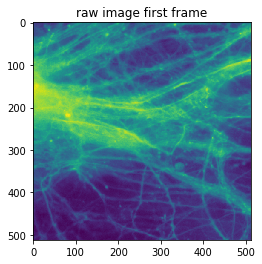

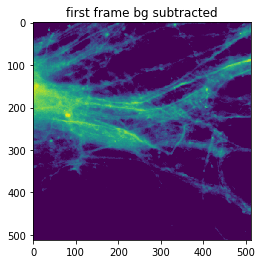

<Figure size 432x288 with 0 Axes>

In [1525]:
randomno=np.random.randint(0,5)
image_name=results["calcium recording filename"][randomno]
image = io.imread(image_name)
print(results["spontaneous or stimulation"][randomno])
plt.figure()
plt.imshow(image[0])
plt.title('raw image first frame')
bg=np.mean(ndi.median_filter(image[0],size=5))+0*np.std(ndi.median_filter(image[0],size=5))
first=image[0]
first=np.subtract(first,bg)
first[first<0]=0
plt.figure()
plt.imshow(first)
plt.title('first frame bg subtracted')
plt.figure()
plt.imshow(results["synapse mask (dilated syt1)"][randomno])
plt.title('synapse mask')

pearson_all_spots_in_image=results["synchronicity (pearson)"][randomno]
aoc_all_spots_in_image=results["total calcium influx (AOC of [f(t)-f(0)]/f(0) in rois)"][randomno]
no_peaks_in_image=results["synchronicity (no. of peaks)"][randomno]
slope=results["calcium slope downwards"][randomno]

plt.figure()
plt.plot(results["calcium [f(t)-f(0)]/f(0) in rois"][randomno])
plt.title('df/f under rois')
plt.figure()
plt.plot(results["df/f under dilated syt mask"][randomno])
plt.title('df/f under syt')

print('pearson  '+str(pearson_all_spots_in_image))
print('aoc  '+str(aoc_all_spots_in_image))
print('no peaks '+str(no_peaks_in_image))
print('slope. '+str(slope))

In [58]:
df=pd.DataFrame(results)

In [59]:
for key in results.keys():
    print(key)
    print(len(results[key]))

calcium recording filename
7
corresponding syt/clumps filename
7
clumpschannelno
7
synapsechannelno
7
spontaneous or stimulation
7
magnification
7
Manual mask from matlab GUI
7
calcium mean intensity whole frame
7
calcium mean intensity in rois
7
calcium mean intensity in rois - vector for each roi
7
calcium [f(t)-f(0)]/f(0) in rois
7
calcium [f(t)-f(0)]/f(0) in rois - vector for each roi
7
total calcium influx (AOC of [f(t)-f(0)]/f(0) in rois)
7
calcium slope downwards
7
synchronicity (pearson)
7
synchronicity (no. of peaks)
7


In [60]:
df

,calcium recording filename,corresponding syt/clumps filename,clumpschannelno,synapsechannelno,spontaneous or stimulation,magnification,Manual mask from matlab GUI,calcium mean intensity whole frame,calcium mean intensity in rois,calcium mean intensity in rois - vector for each roi,calcium [f(t)-f(0)]/f(0) in rois,calcium [f(t)-f(0)]/f(0) in rois - vector for each roi,total calcium influx (AOC of [f(t)-f(0)]/f(0) in rois),calcium slope downwards,synchronicity (pearson),synchronicity (no. of peaks)
0,/Volumes/ukps-all$/AG-Rizzoli/Tal/FromSinem/19...,no image,1,2,stim,20x,"[[False, False, False, False, False, False, Fa...","[28.66997528076172, 603.3260726928711, 604.233...","[985.860988987326, 986.1197513354077, 981.2308...","[[586.6731782342061, 587.362414095201, 586.619...","[-0.02064596547684446, -0.020442625784821186, ...","[[0.007958473585084315, 0.009142644179825726, ...",-0.713186,0.000856,0.453114,6
1,/Volumes/ukps-all$/AG-Rizzoli/Tal/FromSinem/19...,no image,1,2,stim,20x,"[[False, False, False, False, False, False, Fa...","[59.519287109375, 558.6021423339844, 558.39731...","[1403.7502008218933, 1403.6152814560894, 1400....","[[519.6110504563663, 519.3426141709775, 518.87...","[0.0028758495437048075, 0.0028843778937333127,...","[[0.03825432871949295, 0.03771795610954645, 0....",-0.874632,-0.001642,0.987071,1
2,/Volumes/ukps-all$/AG-Rizzoli/Tal/FromSinem/19...,no image,1,2,stim,20x,"[[False, False, False, False, False, False, Fa...","[35.12533950805664, 721.5154190063477, 710.150...","[939.8393897300347, 921.4619844024039, 880.766...","[[712.0906893485958, 700.9616349405433, 694.15...","[0.06630879412969189, 0.04657385674902844, -0....","[[0.038348971783491746, 0.02212092334194437, 0...",0.448699,0.003777,0.701480,8
3,/Volumes/ukps-all$/AG-Rizzoli/Tal/FromSinem/19...,no image,1,2,stim,20x,"[[False, False, False, False, False, False, Fa...","[25.922447204589844, 990.4331092834473, 985.20...","[1228.0631656971987, 1193.4994478825151, 1175....","[[983.3518308795772, 979.1068016329834, 977.15...","[0.03602373430582647, 0.014633733851609775, 0....","[[0.10185737092581446, 0.09710076538721374, 0....",-0.433995,-0.004662,0.945798,3
4,/Volumes/ukps-all$/AG-Rizzoli/Tal/FromSinem/19...,no image,1,2,stim,20x,"[[False, False, False, False, False, False, Fa...","[262.34615325927734, 4087.5197525024414, 4075....","[4757.677021374296, 4736.4845921337555, 4736.4...","[[4044.594198458512, 4032.8467904479344, 4033....","[-0.007439728656389224, -0.011877782680005255,...","[[0.008691876913289532, 0.005762160246146051, ...",-0.427963,-0.000220,0.664823,1
5,/Volumes/ukps-all$/AG-Rizzoli/Tal/FromSinem/19...,no image,1,2,stim,20x,"[[False, False, False, False, False, False, Fa...","[299.6583938598633, 6634.201641082764, 6631.43...","[7435.621685871879, 7434.831974919757, 7459.02...","[[6598.45822570518, 6595.580643622982, 6615.60...","[0.0026914445501157523, 0.0025695021340008837,...","[[0.006381215897599853, 0.005942333895824725, ...",0.150195,0.000183,0.704649,4
6,/Volumes/ukps-all$/AG-Rizzoli/Tal/FromSinem/19...,no image,1,2,stim,20x,"[[False, False, False, False, False, False, Fa...","[197.92633438110352, 4040.1295623779297, 4041....","[4919.467942031276, 4921.80000315631, 4897.957...","[[3998.8991270033466, 4000.0761916860865, 3978...","[0.0007553044349794975, 0.001273690324927855, ...","[[0.019983961160652725, 0.020284190563674212, ...",-0.273206,-0.000285,0.769186,1


In [11]:
df["condition"]='None'
for i in range(0,len(df)):
    if "Clump" in df["calcium recording filename"][i].split('/')[-3]:
        df["condition"][i]="Clumps"
    elif "Ctrl" in df["calcium recording filename"][i].split('/')[-3]:
        df["condition"][i]="Ctrl"
        

/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [1622]:
len(df[df["spontaneous or stimulation"]=="Ignore"])

2

In [12]:
for i in range(0,len(df["spontaneous or stimulation"])):
    if df["spontaneous or stimulation"][i]=="spontaneous":
        print('yes')
        if len(df["calcium [f(t)-f(0)]/f(0) in rois"][i])<100:
            print(len(df["calcium [f(t)-f(0)]/f(0) in rois"][i]))
            df["spontaneous or stimulation"][i]="Ignore"
        else:
            print('bigger')
            continue

yes
bigger
yes
39
yes
bigger
yes
bigger
yes
39
yes
bigger
yes
bigger
yes
bigger
yes
bigger
yes
bigger
yes
bigger
yes
bigger
yes
bigger
yes
bigger
yes
bigger
yes
bigger
yes
bigger


/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [13]:
dfclumps=df[df["condition"]=="Clumps"]
dfctrl=df[df["condition"]=="Ctrl"]

In [1519]:
df.columns

Index(['calcium recording filename', 'corresponding syt/clumps filename',
       'clumpschannelno', 'synapsechannelno', 'spontaneous or stimulation',
       'magnification', 'Manual mask from matlab GUI',
       'calcium mean intensity whole frame', 'calcium mean intensity in rois',
       'calcium mean intensity in rois - vector for each roi',
       'calcium [f(t)-f(0)]/f(0) in rois',
       'calcium [f(t)-f(0)]/f(0) in rois - vector for each roi',
       'total calcium influx (AOC of [f(t)-f(0)]/f(0) in rois)',
       'calcium slope downwards', 'synchronicity (pearson)',
       'synchronicity (no. of peaks)', 'condition'],
      dtype='object')

<Figure size 432x288 with 0 Axes>

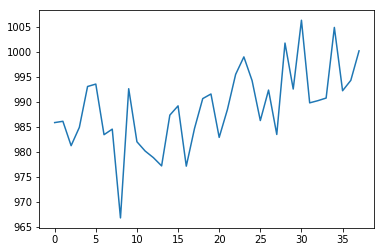

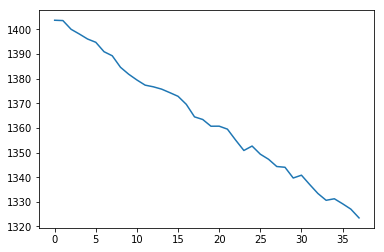

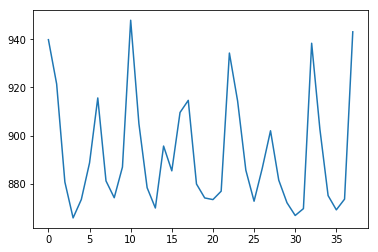

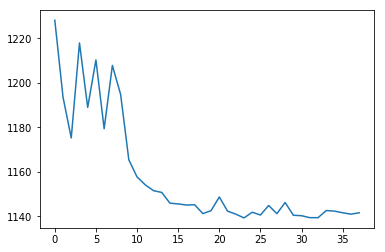

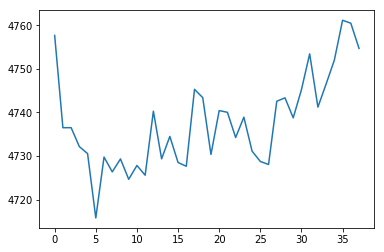

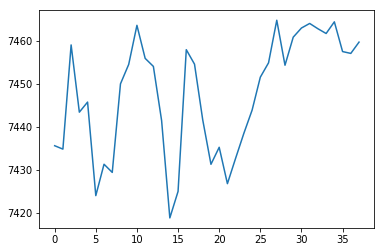

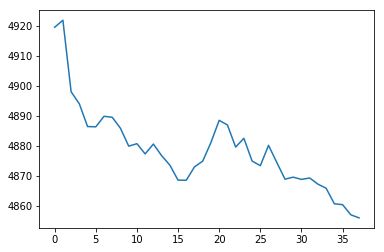

In [76]:
var="calcium mean intensity in rois"
plt.figure()
for i in range(0,len(df)):
    plt.figure()
    plt.plot(df[var][i])




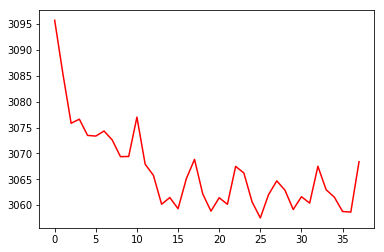

In [75]:
plt.plot(np.mean(df[var].values,axis=0),color='red')



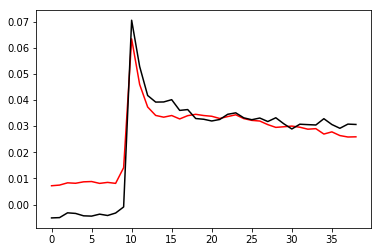

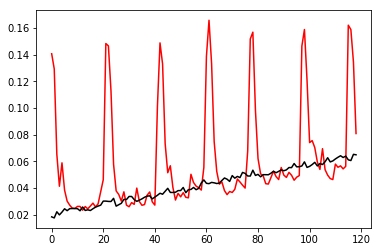

In [16]:
var="calcium [f(t)-f(0)]/f(0) in rois"
#var="calcium mean intensity whole frame"
#var="calcium mean intensity in rois"
plt.figure()
plt.plot(np.mean(dfclumps[dfclumps["spontaneous or stimulation"]=="stim"][var].values,axis=0),color='red')
plt.plot(np.mean(dfctrl[dfctrl["spontaneous or stimulation"]=="stim"][var].values,axis=0),color='black')
#plt.ylim([0,0.08])
plt.figure()
plt.plot(np.mean(dfclumps[dfclumps["spontaneous or stimulation"]=="spontaneous"][var].values,axis=0),color='red')
plt.plot(np.mean(dfctrl[dfctrl["spontaneous or stimulation"]=="spontaneous"][var].values,axis=0),color='black')
#plt.ylim([0,0.25])


In [33]:
dfctrl_sp=dfclumps[dfclumps["spontaneous or stimulation"]=="spontaneous"]



In [36]:
dfctrl_sp[['calcium recording filename','calcium mean intensity in rois - vector for each roi']]

,calcium recording filename,calcium mean intensity in rois - vector for each roi
0,/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/L...,"[[830.0737190527663, 782.0366279046748, 645.22..."
8,/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/L...,"[[567.3701164799643, 567.2479000963368, 567.57..."
14,/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/L...,"[[658.4942914495972, 657.3696419486763, 657.56..."
18,/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/L...,"[[562.1839125636201, 559.5087817504744, 557.64..."
42,/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/L...,"[[914.3456550907656, 918.7113259668508, 915.03..."
43,/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/L...,"[[649.7733123092099, 651.7889561212046, 654.54..."
49,/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/L...,"[[1336.1999143650642, 1332.6827657727374, 1335..."


In [ ]:
dfctrl[""]

In [71]:
var1='calcium recording filename'
var2="calcium mean intensity in rois - vector for each roi"

In [ ]:
var1='calcium recording filename'
var2="calcium mean intensity in rois - vector for each roi"
a=dfctrl_sp[var1].values
list=[]
for i in range(0,len(a)):
    b=a[i]
    list.append(b)
#y = np.vstack(list)
np.savetxt(expdir+'teset.csv',list)

In [62]:
a=dfctrl_sp[var1].values
list=[]
for i in range(0,len(a)):
    b=a[i]
    list.append(b)
#y = np.vstack(list)
np.savetxt(expdir+'teset.csv',list)

TypeError: Mismatch between array dtype ('<U166') and format specifier ('%.18e')

In [70]:
len(dfctrl_sp)

30

In [68]:
a=dfctrl_sp[var1]
#a.to_csv(expdir+'test.csv',sep=;)

In [69]:
a

26    /Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/L...
27    /Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/L...
28    /Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/L...
29    /Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/L...
30    /Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/L...
32    /Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/L...
33    /Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/L...
34    /Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/L...
35    /Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/L...
36    /Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/L...
50    /Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/L...
51    /Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/L...
52    /Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/L...
53    /Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/L...
54    /Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/L...
57    /Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/L...
58    /Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/L...
59    /Volumes/ukps-all$/user/tdanko/Imaging/1_E

In [180]:
dfctrl_sp=dfclumps[dfclumps["spontaneous or stimulation"]=="stim"]
a=dfctrl_sp[var].dropna().values.ravel()
list=[]
list2=[]
for i in range(0,len(a)):
    b=a[i].tolist()
    list.append(b)
    print(len(a[i]))
    if len(b)==39:
        list2.append(dfctrl_sp[var1].values[i])
    else:
        for j in range(0,len(a[i])):
            list2.append(dfctrl_sp[var1].values[i])
y = np.vstack(list)
print('clumps stim: '+str(y.shape[0]))
np.savetxt(expdir+'clumps_stim.csv',y)
np.savetxt(expdir+"clumps_stim_names.csv", list2, delimiter=",", fmt='%s')

print(len(list2))

39
39
39
2
2
2
3
2
3
3
2
3
5
16
14
9
9
10
10
8
9
5
7
9
9
7
8
10
6
clumps stim: 176
176


## svae sinem stuff


In [68]:
df.columns

Index(['calcium recording filename', 'corresponding syt/clumps filename',
       'clumpschannelno', 'synapsechannelno', 'spontaneous or stimulation',
       'magnification', 'Manual mask from matlab GUI',
       'calcium mean intensity whole frame', 'calcium mean intensity in rois',
       'calcium mean intensity in rois - vector for each roi',
       'calcium [f(t)-f(0)]/f(0) in rois',
       'calcium [f(t)-f(0)]/f(0) in rois - vector for each roi',
       'total calcium influx (AOC of [f(t)-f(0)]/f(0) in rois)',
       'calcium slope downwards', 'synchronicity (pearson)',
       'synchronicity (no. of peaks)'],
      dtype='object')

In [73]:
var="calcium mean intensity in rois - vector for each roi"
var1="calcium recording filename"
import csv
dfctrl_sp=df
a=dfctrl_sp[var].dropna().values.ravel()
list=[]
list2=[]
for i in range(0,len(a)):
    b=a[i].tolist()
    list.append(b)
    for j in range(0,len(a[i])):
        list2.append(dfctrl_sp[var1].values[i])
y = np.vstack(list)
print('clumps spontaneous: '+str(y.shape[0]))
np.savetxt(expdir+'basal.csv',y)
np.savetxt(expdir+"basal_names.csv", list2, delimiter=",", fmt='%s')

clumps spontaneous: 53


In [177]:
dfctrl_sp[var1].values[i]

'/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/201910_biotinclumps_tnr_calciumimaging/20191016_Clumps1/60x_post_ttx_stim/60x_field1_stim.tif'

## my stuff

In [104]:
import csv
dfctrl_sp=dfclumps[dfclumps["spontaneous or stimulation"]=="spontaneous"]
a=dfctrl_sp[var].dropna().values.ravel()
list=[]
list2=[]
for i in range(0,len(a)):
    b=a[i].tolist()
    list.append(b)
    for j in range(0,len(a[i])):
        list2.append(dfctrl_sp[var1].values[i])
y = np.vstack(list)
print('clumps spontaneous: '+str(y.shape[0]))
np.savetxt(expdir+'clumps_spontaneous.csv',y)
np.savetxt(expdir+"clumps_spontaneous_names.csv", list2, delimiter=",", fmt='%s')

dfctrl_sp=dfclumps[dfclumps["spontaneous or stimulation"]=="stim"]
a=dfctrl_sp[var].dropna().values.ravel()
list=[]
list2=[]
for i in range(0,len(a)):
    b=a[i].tolist()
    list.append(b)
    for j in range(0,len(a[i])):
        list2.append(dfctrl_sp[var1].values[i])
y = np.vstack(list)
print('clumps stim: '+str(y.shape[0]))
np.savetxt(expdir+'clumps_stim.csv',y)
np.savetxt(expdir+"clumps_stim_names.csv", list2, delimiter=",", fmt='%s')

dfctrl_sp=dfctrl[dfctrl["spontaneous or stimulation"]=="spontaneous"]
a=dfctrl_sp[var].dropna().values.ravel()
list=[]
list2=[]
for i in range(0,len(a)):
    b=a[i].tolist()
    list.append(b)
    for j in range(0,len(a[i])):
        list2.append(dfctrl_sp[var1].values[i])
y = np.vstack(list)
print('ctrl spontaneous: '+str(y.shape[0]))
np.savetxt(expdir+'ctrls_spontaneous.csv',y)
np.savetxt(expdir+"ctrls_spontaneous_names.csv", list2, delimiter=",", fmt='%s')

dfctrl_sp=dfctrl[dfctrl["spontaneous or stimulation"]=="stim"]
a=dfctrl_sp[var].dropna().values.ravel()
list=[]
list2=[]
for i in range(0,len(a)):
    b=a[i].tolist()
    list.append(b)
    for j in range(0,len(a[i])):
        list2.append(dfctrl_sp[var1].values[i])
y = np.vstack(list)
print('ctrl stim: '+str(y.shape[0]))
np.savetxt(expdir+'ctrls_stim.csv',y)
np.savetxt(expdir+"ctrls_stim_names.csv", list2, delimiter=",", fmt='%s')

clumps spontaneous: 75
clumps stim: 176
ctrl spontaneous: 74
ctrl stim: 271


In [142]:
counter=0
counteri=0
dfctrl_sp=dfclumps[dfclumps["spontaneous or stimulation"]=="stim"]
a=dfctrl_sp[var].dropna().values.ravel()
list=[]
list2=[]
for i in range(0,len(a)):
    print(i)
    print(len(a[i]))
    print(len(b))
    b=a[i].tolist()
    list.append(b)
    for j in range(0,len(a[i])):
        counter+=1
        list2.append(dfctrl_sp[var1].values[i])
y = np.vstack(list)
print('clumps stim: '+str(y.shape[0]))
print(len(list2))
np.savetxt(expdir+'clumps_stim.csv',y)
np.savetxt(expdir+"clumps_stim_names.csv", list2, delimiter=",", fmt='%s')

0
39
6
1
39
39
2
39
39
3
2
39
4
2
2
5
2
2
6
3
2
7
2
3
8
3
2
9
3
3
10
2
3
11
3
2
12
5
3
13
16
5
14
14
16
15
9
14
16
9
9
17
10
9
18
10
10
19
8
10
20
9
8
21
5
9
22
7
5
23
9
7
24
9
9
25
7
9
26
8
7
27
10
8
28
6
10
clumps stim: 176
290


In [140]:
b

[[1082.9274145985628,
  1086.5053041237913,
  1086.5849358228181,
  1085.831013021682,
  1083.9049758656547,
  1083.282511523956,
  1084.7087194052551,
  1085.3076236594186,
  1086.1928807561578,
  1088.7806296658441,
  1161.3364180285887,
  1127.4485108100139,
  1107.2125995250733,
  1102.1490703232917,
  1101.6150727134454,
  1098.9117583150967,
  1099.9480762365943,
  1101.0489593518648,
  1104.981550030265,
  1103.3685299002034,
  1101.2606742096195,
  1102.8387732613182,
  1105.1707563129548,
  1107.1369139079015,
  1106.0874307398612,
  1106.210345175459,
  1104.1711443249367,
  1104.688228492496,
  1105.2843351802703,
  1105.6067071751177,
  1104.9523948099518,
  1110.8051908242926,
  1104.3478954230106,
  1102.8895795502165,
  1104.1549758656547,
  1108.2104382983346,
  1103.5343507007497,
  1102.4541835451878,
  1102.6312372926077],
 [4937.561674008811,
  4955.625550660793,
  4972.26321585903,
  4972.215859030837,
  4988.523127753304,
  4944.2323788546255,
  4958.898678414097,

In [17]:
#clumps
dfcalc=dfclumps[dfclumps["spontaneous or stimulation"]=="spontaneous"]
print('Area under curve: '+str(dfcalc["total calcium influx (AOC of [f(t)-f(0)]/f(0) in rois)"].mean()))
print('calcium slope downwards: '+str(dfcalc["calcium slope downwards"].mean()))
print('Pearson: '+str(dfcalc["synchronicity (pearson)"].mean()))
print('No peaks: '+str(dfcalc["synchronicity (no. of peaks)"].mean()))

Area under curve: 7.004430245826258
calcium slope downwards: nan
Pearson: 0.7819361236842871
No peaks: 1.1428571428571428


In [ ]:
a

In [18]:
#clumps
dfcalc=dfclumps[dfclumps["spontaneous or stimulation"]=="stim"]
print('Area under curve: '+str(dfcalc["total calcium influx (AOC of [f(t)-f(0)]/f(0) in rois)"].mean()))
print('calcium slope downwards: '+str(dfcalc["calcium slope downwards"].mean()))
print('Pearson: '+str(dfcalc["synchronicity (pearson)"].mean()))
print('No peaks: '+str(dfcalc["synchronicity (no. of peaks)"].mean()))

Area under curve: 1.026716488450117
calcium slope downwards: 0.0032232842324663707
Pearson: 0.8394805651724799
No peaks: 1.9655172413793103


In [19]:
#ctrl
dfcalc=dfctrl[dfctrl["spontaneous or stimulation"]=="spontaneous"]
print('Area under curve: '+str(dfcalc["total calcium influx (AOC of [f(t)-f(0)]/f(0) in rois)"].mean()))
print('calcium slope downwards: '+str(dfcalc["calcium slope downwards"].mean()))
print('Pearson: '+str(dfcalc["synchronicity (pearson)"].mean()))
print('No peaks: '+str(dfcalc["synchronicity (no. of peaks)"].mean()))

Area under curve: 4.984013495333892
calcium slope downwards: nan
Pearson: 0.7032621651242337
No peaks: 1.25


In [20]:
#clumps
dfcalc=dfctrl[dfctrl["spontaneous or stimulation"]=="stim"]
print('Area under curve: '+str(dfcalc["total calcium influx (AOC of [f(t)-f(0)]/f(0) in rois)"].mean()))
print('calcium slope downwards: '+str(dfcalc["calcium slope downwards"].mean()))
print('Pearson: '+str(dfcalc["synchronicity (pearson)"].mean()))
print('No peaks: '+str(dfcalc["synchronicity (no. of peaks)"].mean()))

Area under curve: 0.9751001689660524
calcium slope downwards: 0.005097903397366347
Pearson: 0.703883134113918
No peaks: 3.6666666666666665


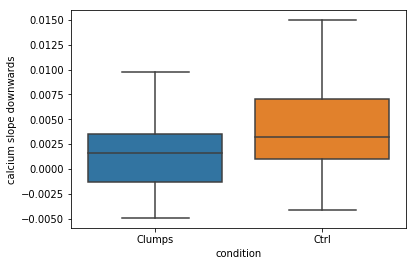

In [31]:
var="total calcium influx (AOC of [f(t)-f(0)]/f(0) in rois)"
#var="synchronicity (pearson)"
#var="synchronicity (no. of peaks)"
var="calcium slope downwards"

df2show=df[df["spontaneous or stimulation"]=="stim"]

sns.boxplot(x="condition",y=var,data=df2show,showfliers=False)
#sns.swarmplot(x="condition",y=var,data=df2show,color='k')